# Introduction to AutoRA & Closed-Loop Experimentation

Welcome to the AutoRA framework! In this tutorial, you'll learn how to build automated closed-loop experiments that intelligently select which conditions to test next.

## Learning Objectives

By the end of this tutorial, you will be able to:
- Understand the AutoRA workflow (State → Experimentalist → Runner → Theorist)
- Build a simple closed-loop experiment
- Compare different experimentalist strategies (grid vs. random)
- Evaluate experimental design efficiency

## Why Closed-Loop Experimentation?

Traditional experiments:
1. Design all conditions upfront
2. Run all trials
3. Analyze data
4. (Maybe) design follow-up study

Closed-loop experiments:
1. Start with small set of conditions
2. Run trials → Fit model → Identify informative conditions
3. Repeat step 2 until budget exhausted
4. Result: More efficient use of resources!

## The AutoRA Framework

AutoRA consists of three main components:

```
┌─────────────────┐
│ Experimentalist │ ← Proposes new conditions to test
└────────┬────────┘
         ↓
┌─────────────────┐
│ Experiment      │ ← Runs experiments, collects data
│ Runner          │
└────────┬────────┘
         ↓
┌─────────────────┐
│ Theorist        │ ← Builds model to explain data
└────────┬────────┘
         ↓
  (Loop back to Experimentalist)
```

All components communicate via a **State** object that contains:
- Variables (independent/dependent)
- Conditions (to be tested)
- Experiment data (collected so far)
- Models (current best explanation)

## Setup & Imports

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

np.random.seed(42)

# Add project folder to path
target_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))
if target_folder not in sys.path:
    sys.path.append(target_folder)

## Part 1: Understanding the Experiment Runner

First, let's import our 2AFC experiment. The experiment runner wraps our synthetic experiment into a format AutoRA can use.

In [2]:
from resources.synthetic import twoafc

# Define participant parameters
n_units = 100
parameters = np.random.normal(1, 0.5, (n_units, 2))
parameters = np.where(parameters < 0, 0.1, parameters)

# Create experiment
experiment = twoafc(parameters, resolution=100)

# Let's see what it looks like
print("Experiment created!")
print(f"Number of participants: {n_units}")
print(f"\nIndependent Variables: {[iv.name for iv in experiment.variables.independent_variables]}")
print(f"Dependent Variables: {[dv.name for dv in experiment.variables.dependent_variables]}")

Experiment created!
Number of participants: 100

Independent Variables: ['participant_id', 'ratio', 'scatteredness']
Dependent Variables: ['response_time']


Let's run a single trial to see what happens:

In [3]:
# Run experiment with one condition
test_conditions = np.array([[0, 0.5, 0.5]])  # [participant_id, ratio, scatteredness]
result = experiment.run(test_conditions, random_state=42)

print("Experimental result:")
print(result)
print(f"\nParticipant {int(result['participant_id'][0])} with ratio={result['ratio'][0]:.2f} and scatteredness={result['scatteredness'][0]:.2f} had response time={result['response_time'][0]:.3f}s")

Experimental result:
   participant_id  ratio  scatteredness  response_time
0             0.0    0.5            0.5       0.524543

Participant 0 with ratio=0.50 and scatteredness=0.50 had response time=0.525s


Visualize the underlying ground truth:

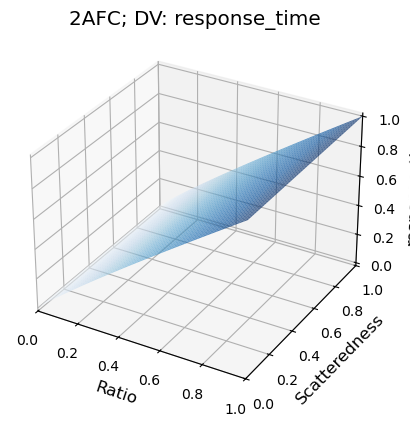

In [4]:
experiment.plotter()

## Part 2: Understanding States

The State is the central data structure in AutoRA. It keeps track of everything:

In [5]:
from autora.state import StandardState

# Get variable names
iv_names = [iv.name for iv in experiment.variables.independent_variables]
dv_names = [dv.name for dv in experiment.variables.dependent_variables]

# Initialize with empty state
state = StandardState(
    variables=experiment.variables,
    conditions=pd.DataFrame(columns=iv_names),  # No conditions yet
    experiment_data=pd.DataFrame(columns=iv_names + dv_names),  # No data yet
    models=[]  # No model yet
)

print("State created!")
print(f"Variables: {len(state.variables.independent_variables)} IVs, {len(state.variables.dependent_variables)} DVs")
print(f"Conditions: {len(state.conditions)} rows")
print(f"Experiment data: {len(state.experiment_data)} rows")
print(f"Models: {len(state.models)}")

State created!
Variables: 3 IVs, 1 DVs
Conditions: 0 rows
Experiment data: 0 rows
Models: 0


## Part 3: Your First Experimentalist - Grid Sampler

The experimentalist proposes which conditions to test. Let's start with a simple one: **grid sampling**.

Grid sampling creates evenly-spaced points across the design space - just like a factorial design!

In [6]:
from autora.experimentalist.grid import grid_pool
from autora.state import on_state

experiment = twoafc(parameters, resolution=100, discrete_iv=True)

# Wrap grid_pool to work with states
experimentalist_grid = on_state(grid_pool, output=['conditions'])

# Generate grid conditions
# sample_all=['participant_id'] means: generate conditions for ALL participants
# state = experimentalist_grid(state, num_samples=5, sample_all=['participant_id'])
state = experimentalist_grid(state)

print(f"Generated {len(state.conditions)} conditions!")
print("\nFirst few conditions:")
print(state.conditions.head(10))

AssertionError: grid_pool only supports independent variables with discrete allowed values, but allowed_values is None on iv=IV(name='ratio', value_range=(0.0, 1.0), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='ratio', rescale=1, is_covariate=False) 

Visualize the proposed conditions:

In [ ]:
# Plot for one participant
participant_0 = state.conditions[state.conditions['participant_id'] == 0]

plt.figure(figsize=(8, 6))
plt.scatter(participant_0['ratio'], participant_0['scatteredness'], s=100, alpha=0.6)
plt.xlabel('Ratio', fontsize=12)
plt.ylabel('Scatteredness', fontsize=12)
plt.title('Grid Sampling: Proposed Conditions for Participant 0', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.show()

print(f"Grid sampler created {len(participant_0)} evenly-spaced conditions")

## Part 4: Running the Experiment

Now let's collect data for these conditions:

In [ ]:
# Wrap experiment runner to work with states
experiment_runner = on_state(experiment.run, output=['experiment_data'])

# Run experiment
state = experiment_runner(state, added_noise=0.0, random_state=42)

print(f"Collected {len(state.experiment_data)} observations!")
print("\nFirst few observations:")
print(state.experiment_data.head(10))

## Part 5: Training a Model (Theorist)

Now we fit a model to explain the data:

In [ ]:
from resources.regressors import FFN, FFNRegressor
from autora.state import estimator_on_state
from sklearn.metrics import mean_squared_error

# Create model
model = FFNRegressor(FFN(n_units, 2), max_epochs=50, lr=0.1, verbose=False)

# Wrap to work with states
theorist = estimator_on_state(model)

# Store initial model in state
state.models = [model]

# Train!
state = theorist(state)

print("Model trained!")
print(f"State now contains {len(state.models)} model(s)")

Evaluate the model:

In [ ]:
# Make predictions
X = state.experiment_data[iv_names].values
y_true = state.experiment_data[dv_names].values
y_pred = state.models[0].predict(X)

mse = mean_squared_error(y_true, y_pred)
print(f"Model MSE: {mse:.4f}")

# Visualize predictions
experiment.plotter(state.models[0])

## Part 6: Closing the Loop!

Now let's run multiple cycles:

In [ ]:
# Reset state
state_grid = StandardState(
    variables=experiment.variables,
    conditions=pd.DataFrame(columns=iv_names),
    experiment_data=pd.DataFrame(columns=iv_names + dv_names),
    models=[FFNRegressor(FFN(n_units, 2), max_epochs=50, lr=0.1, verbose=False)]
)

# Run 5 cycles
n_cycles = 5
mse_history_grid = []

for cycle in range(n_cycles):
    print(f"\nCycle {cycle + 1}/{n_cycles}")
    
    # 1. Propose conditions
    state_grid = experimentalist_grid(state_grid, num_samples=2, sample_all=['participant_id'])
    
    # 2. Run experiment
    state_grid = experiment_runner(state_grid, added_noise=0.0, random_state=42+cycle)
    
    # 3. Train model
    state_grid = theorist(state_grid)
    
    # 4. Evaluate
    X = state_grid.experiment_data[iv_names].values
    y_true = state_grid.experiment_data[dv_names].values
    y_pred = state_grid.models[0].predict(X)
    mse = mean_squared_error(y_true, y_pred)
    mse_history_grid.append(mse)
    
    print(f"  Total samples: {len(state_grid.experiment_data)}")
    print(f"  MSE: {mse:.4f}")

print("\nClosed-loop experiment complete!")

## Part 7: Comparing Experimentalists

Let's compare grid sampling vs. random sampling:

In [ ]:
from autora.experimentalist.random import random_sample

# Random experimentalist
experimentalist_random = on_state(random_sample, output=['conditions'])

# Reset state
state_random = StandardState(
    variables=experiment.variables,
    conditions=pd.DataFrame(columns=iv_names),
    experiment_data=pd.DataFrame(columns=iv_names + dv_names),
    models=[FFNRegressor(FFN(n_units, 2), max_epochs=50, lr=0.1, verbose=False)]
)

# Run same number of cycles
mse_history_random = []

for cycle in range(n_cycles):
    state_random = experimentalist_random(state_random, num_samples=2, random_state=42+cycle, sample_all=['participant_id'])
    state_random = experiment_runner(state_random, added_noise=0.0, random_state=42+cycle)
    state_random = theorist(state_random)
    
    X = state_random.experiment_data[iv_names].values
    y_true = state_random.experiment_data[dv_names].values
    y_pred = state_random.models[0].predict(X)
    mse = mean_squared_error(y_true, y_pred)
    mse_history_random.append(mse)

print("Comparison complete!")

Plot the comparison:

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_cycles+1), mse_history_grid, 'o-', label='Grid Sampling', linewidth=2)
plt.plot(range(1, n_cycles+1), mse_history_random, 's-', label='Random Sampling', linewidth=2)
plt.xlabel('Cycle', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Experimentalist Comparison: Grid vs Random', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal MSE:")
print(f"  Grid: {mse_history_grid[-1]:.4f}")
print(f"  Random: {mse_history_random[-1]:.4f}")
print(f"\nGrid sampling is {(mse_history_random[-1]/mse_history_grid[-1] - 1)*100:.1f}% better!")

Visualize where each strategy sampled:

In [ ]:
# Get conditions for participant 0
grid_conds = state_grid.experiment_data[state_grid.experiment_data['participant_id'] == 0]
random_conds = state_random.experiment_data[state_random.experiment_data['participant_id'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grid
axes[0].scatter(grid_conds['ratio'], grid_conds['scatteredness'], s=100, alpha=0.6, c=range(len(grid_conds)), cmap='viridis')
axes[0].set_xlabel('Ratio', fontsize=12)
axes[0].set_ylabel('Scatteredness', fontsize=12)
axes[0].set_title('Grid Sampling (Participant 0)', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-0.1, 1.1)
axes[0].set_ylim(-0.1, 1.1)

# Random
axes[1].scatter(random_conds['ratio'], random_conds['scatteredness'], s=100, alpha=0.6, c=range(len(random_conds)), cmap='viridis')
axes[1].set_xlabel('Ratio', fontsize=12)
axes[1].set_ylabel('Scatteredness', fontsize=12)
axes[1].set_title('Random Sampling (Participant 0)', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-0.1, 1.1)
axes[1].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

print(f"Grid: {len(grid_conds)} samples, evenly distributed")
print(f"Random: {len(random_conds)} samples, clustered")

## Summary & Key Takeaways

You've learned:

1. ✅ **AutoRA Workflow**: State → Experimentalist → Runner → Theorist
2. ✅ **State Management**: Central data structure for closed-loop experiments
3. ✅ **Experimentalists**: Grid vs. Random sampling
4. ✅ **Closed-Loop**: Iterative refinement improves model quality

### What's Next?

In the next tutorials, you'll learn:
- **Information theory**: Why some samples are more valuable than others
- **Uncertainty sampling**: Intelligent selection based on model uncertainty
- **Disagreement sampling**: Using model ensembles for even smarter selection

## Exercises

1. **Modify sample size**: Try `num_samples=1` vs `num_samples=10` per cycle. How does this affect convergence?

2. **Add noise**: Change `added_noise=0.0` to `added_noise=0.5`. How do the strategies compare now?

3. **More participants**: Reduce `n_units` to 10. Does this change which strategy is better?

4. **Cycle count**: Run 20 cycles instead of 5. Do the strategies converge to similar performance?

5. **Latin Hypercube**: Try using `from scipy.stats.qmc import LatinHypercube` as an experimentalist. How does it compare?

## Congratulations!

You've completed the AutoRA introduction tutorial! You now understand the fundamentals of closed-loop experimentation and can build your own automated experiment workflows.